<a href="https://colab.research.google.com/github/eric-pierce/MSDS-422-HW/blob/master/epierce_assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Neural Networks
## MSDS-422 Spring 2019 - Eric Pierce
## Background  
The manager of a data science team is looking to implement models for computer vision, and is leveraging the handwritten digit dataset known as MNIST ("Modified National Institute of Standards and Technology") dataset. This was made available in 1999, and is available in the comma delimited files <digit_recognition_train.csv> for the a labled dataset of 42k digits, and <digit_recognition_test.csv> for an unlabled dataset of 58k digits.
## Objective
A financial institution is evaluating machine learning technologies for optical character recognition. This is focused on neural network typology and hyperparameter settings to determine accuracy.

# Setup and Data Import
Initialize the data and libraries used as part of this project

### Library Import and Setting Initialization

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

Using TensorFlow backend.


### Data Import

In [0]:
mnist_train = pd.read_csv("https://raw.githubusercontent.com/eric-pierce/MSDS-422/master/digit_recognition_train.csv")
mnist_test = pd.read_csv("https://raw.githubusercontent.com/eric-pierce/MSDS-422/master/digit_recognition_test.csv")

# Exploratory Data Analysis
*   Clean Data
*   Identify Data Descriptions and Statistics
*   Visualize Input Data

### Clean Data

Examine the shape of original input data

In [0]:
print(mnist_train.shape)

(42000, 785)


After dropping any non-populated values the shape is the same, therefore all values are populated

In [0]:
mnist_train.dropna()
print(mnist_train.shape)

(42000, 785)


Sample rows, each row consists of a label identifying the actual number written, followed by 783 pixels (28x28 image)

In [0]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Identify Data Descriptions and Statistics

Descriptive statistics for all pixels won't be very helpful as there are so many of them.

The mean value for label is 4.4 and the standard deviation is 2.8, so there is a good distribution across digits 0-9.

In [0]:
pd.DataFrame(mnist_train['label'].describe())

,label
count,42000.000000
mean,4.456643
std,2.887730
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


### Visualize Input Data

#### Sample Digit Image

Selecting and rending one row as an image

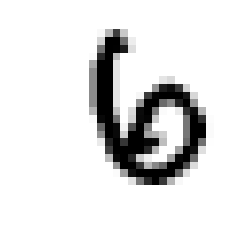

In [0]:
plt.imshow(mnist_train.iloc[3500, 1:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

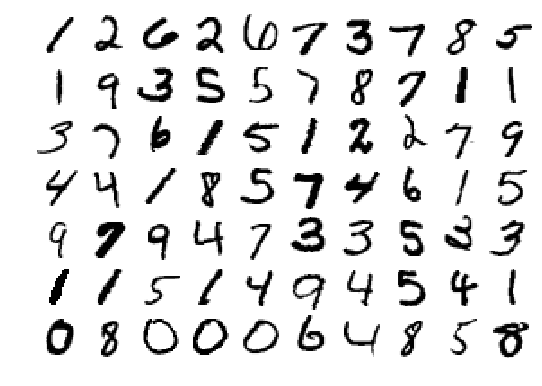

In [0]:
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')

plt.figure(figsize=(9,9))
example_images = np.r_[mnist_train.iloc[:12000:600, 1:], mnist_train.iloc[13000:30600:600, 1:], mnist_train.iloc[30600:60000:590, 1:]]
plot_digits(example_images, images_per_row=10)
plt.show()

#### Numeric Parameter Histograms

The discriptive statistic analysis already indicated good coverage across digits in the training file, and a histogram visualizes that distribution.

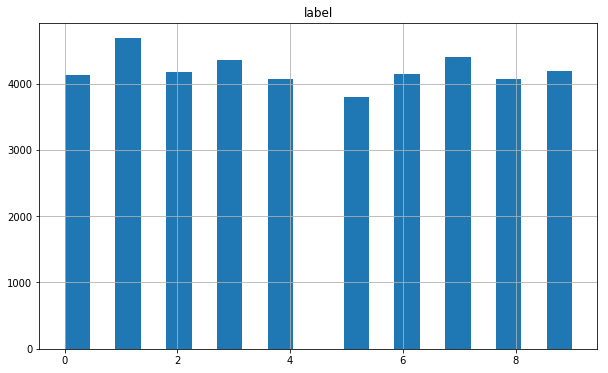

In [0]:
mnist_train[['label']].hist(bins=20, figsize=(10,6))
plt.show()

By examining a Histogram of the pixel values, we can see that the data ranges from 0-255, indicating that it is grayscale as opposed to 0 or 1 for black and white.

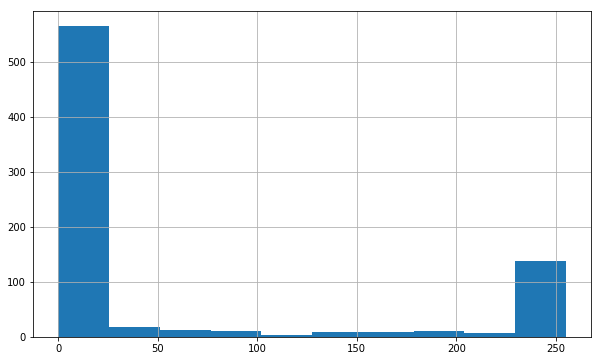

In [0]:
mnist_train.iloc[:, 1:].iloc[1].hist(figsize=(10,6))
plt.show()

#### Construct Average Digit Images

First we can examine what the average digit looks like

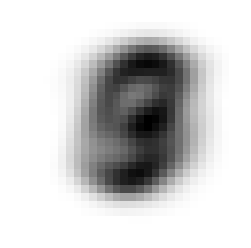

In [0]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.axis("off")
plt.show()

Here we can construct average images for the 10 digits by taking the mean of all images with the same label

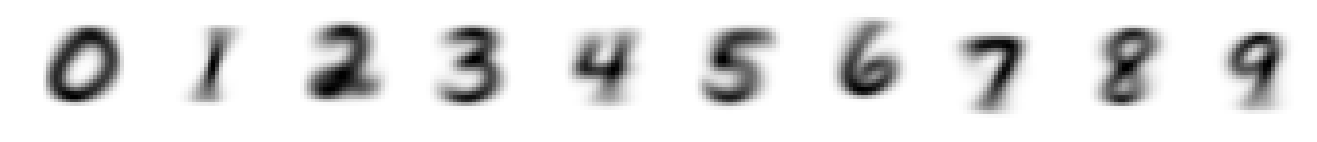

In [0]:
fig = plt.figure(figsize=(23,5))
digit_count=len(mnist_train.groupby('label').mean())
for i in range(digit_count):
  fig.add_subplot(1,digit_count,i+1)
  plt.imshow(mnist_train.groupby('label').mean().iloc[i, 0:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
  plt.axis("off")

# Initial Tensorflow Model Training with Keras

### Model Definition and Training

In [0]:
training_images = mnist_train.iloc[:, 1:]
training_labels = mnist_train.iloc[:, 0]

from sklearn.model_selection import train_test_split

training_images_scaled = training_images.astype('float32')/255.0
mnist_test_scaled = mnist_test/255.0

x_train, x_test, y_train, y_test = train_test_split(training_images_scaled, training_labels, random_state=RANDOM_SEED)

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
batch_size = 90
epochs = 20

#Running a sequence
keras_model = Sequential()
keras_model.add(Dense(512, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(num_classes, activation='softmax'))

keras_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
start=datetime.datetime.now()
keras_model.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, verbose=1, 
                validation_data=(x_test, y_test))
end=datetime.datetime.now()
time1=end-start
print("Time required to fit",end-start)
score1=keras_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Instructions for updating:
Use tf.cast instead.
Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 3s 100us/step - loss: 0.2994 - acc: 0.9086 - val_loss: 0.1563 - val_acc: 0.9510
Epoch 2/20
31500/31500 [==============================] - 2s 69us/step - loss: 0.1275 - acc: 0.9608 - val_loss: 0.1003 - val_acc: 0.9689
Epoch 3/20
31500/31500 [==============================] - 2s 69us/step - loss: 0.0914 - acc: 0.9723 - val_loss: 0.1065 - val_acc: 0.9688
Epoch 4/20
31500/31500 [==============================] - 2s 76us/step - loss: 0.0691 - acc: 0.9788 - val_loss: 0.0881 - val_acc: 0.9757
Epoch 5/20
31500/31500 [==============================] - 2s 77us/step - loss: 0.0548 - acc: 0.9828 - val_loss: 0.1215 - val_acc: 0.9706
Epoch 6/20
31500/31500 [==============================] - 2s 79us/step - loss: 0.0482 - acc: 0.9843 - val_loss: 0.0938 - val_acc: 0.9754
Epoch 7/20
31500/31500 [==============================] - 2s 77us/step - loss: 

In [0]:
keras_submission = pd.DataFrame()
keras_submission['Label'] = keras_model.predict_classes(mnist_test_scaled, verbose=1)
keras_submission.index += 1
keras_submission.index.name = 'ImageId'

28000/28000 [==============================] - 1s 30us/step


Run model on test dataset

### Model Results and Submission

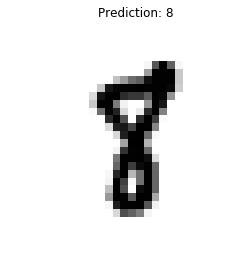

In [0]:
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(keras_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

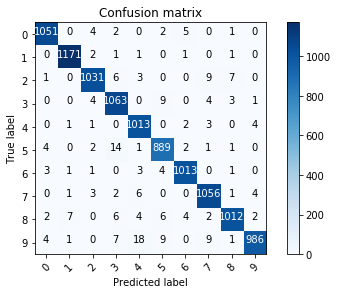

In [0]:
#Note this function was found online and was created by Yassine Ghouzam
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
validation_prediction = keras_model.predict(x_test)
# Convert predictions classes to one hot vectors 
validation_prediction_classes = np.argmax(validation_prediction, axis = 1)
# Convert validation observations to one hot vectors
y_test_one_hot = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion = confusion_matrix(y_test_one_hot, validation_prediction_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion, classes = range(10))


Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_6/keras_submission_cnn1.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.98000

In [0]:
results_df = pd.DataFrame({'TestName': 'Initial Dense CNN',
   'NumberOfLayers': [5],
   'NodesPerLayer': [512],
   'ProcessingTime': [time1],
   'TrainingSetAccuracy': [score1[1]],
   'TestSetAccuracy': [0.98000]})
results_df.set_index('TestName', inplace=True)

# Second Tensorflow Model Training with Keras

### Model Definition and Training

In [0]:
batch_size = 100
epochs = 20
num_classes = 10

#Running a sequence
keras_model = Sequential()
keras_model.add(Dense(300, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(num_classes, activation='softmax'))

keras_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


In [0]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


In [0]:
start=datetime.datetime.now()
keras_model.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, verbose=1, 
                validation_data=(x_test, y_test))
end=datetime.datetime.now()
time2=end-start
print("Time required to fit",end-start)
score2=keras_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 2s 66us/step - loss: 0.3713 - acc: 0.8903 - val_loss: 0.1882 - val_acc: 0.9456
Epoch 2/20
31500/31500 [==============================] - 2s 61us/step - loss: 0.1753 - acc: 0.9486 - val_loss: 0.1375 - val_acc: 0.9579
Epoch 3/20
31500/31500 [==============================] - 2s 60us/step - loss: 0.1247 - acc: 0.9623 - val_loss: 0.1123 - val_acc: 0.9644
Epoch 4/20
31500/31500 [==============================] - 2s 60us/step - loss: 0.0963 - acc: 0.9717 - val_loss: 0.1040 - val_acc: 0.9682
Epoch 5/20
31500/31500 [==============================] - 2s 60us/step - loss: 0.0783 - acc: 0.9766 - val_loss: 0.0941 - val_acc: 0.9712
Epoch 6/20
31500/31500 [==============================] - 2s 59us/step - loss: 0.0661 - acc: 0.9794 - val_loss: 0.0868 - val_acc: 0.9747
Epoch 7/20
31500/31500 [==============================] - 2s 60us/step - loss: 0.0538 - acc: 0.9835 - val_loss: 0.0884 - val_acc

In [0]:
keras_submission = pd.DataFrame()
keras_submission['Label'] = keras_model.predict_classes(mnist_test_scaled, verbose=1)
keras_submission.index += 1
keras_submission.index.name = 'ImageId'

28000/28000 [==============================] - 1s 28us/step


Run model on test dataset

### Model Results and Submission

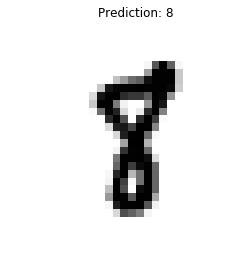

In [0]:
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(keras_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

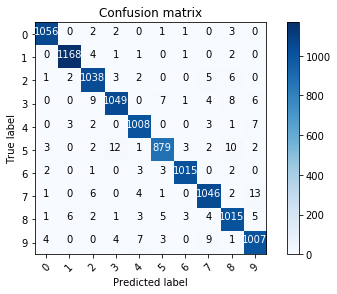

In [0]:
#Note this function was found online and was created by Yassine Ghouzam
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
validation_prediction = keras_model.predict(x_test)
# Convert predictions classes to one hot vectors 
validation_prediction_classes = np.argmax(validation_prediction, axis = 1)
# Convert validation observations to one hot vectors
y_test_one_hot = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion = confusion_matrix(y_test_one_hot, validation_prediction_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion, classes = range(10))


Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_6/keras_submission_cnn2.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.97471

In [0]:
results_df2=(pd.DataFrame({'TestName': 'Second Dense CNN',
   'NumberOfLayers': [3],
   'NodesPerLayer': [300],
   'ProcessingTime': [time2],
   'TrainingSetAccuracy': [score2[1]],
   'TestSetAccuracy': [0.97471]}))
results_df2.set_index('TestName', inplace=True)
results_df2

,NumberOfLayers,NodesPerLayer,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,
Second Dense CNN,3,300,00:00:38.751420,0.979143,0.97471


# Third Tensorflow Model Training with Keras

### Model Definition and Training

In [0]:
batch_size = 100
epochs = 20
num_classes = 10

#Running a sequence
keras_model = Sequential()
keras_model.add(Dense(512, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(512, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(512, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(num_classes, activation='softmax'))

keras_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


In [0]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total para

In [0]:
start=datetime.datetime.now()
keras_model.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, verbose=1, 
                validation_data=(x_test, y_test))
end=datetime.datetime.now()
time3=end-start
print("Time required to fit",end-start)
score3=keras_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 3s 80us/step - loss: 0.3324 - acc: 0.8946 - val_loss: 0.1609 - val_acc: 0.9506
Epoch 2/20
31500/31500 [==============================] - 2s 73us/step - loss: 0.1464 - acc: 0.9570 - val_loss: 0.0992 - val_acc: 0.9699
Epoch 3/20
31500/31500 [==============================] - 2s 77us/step - loss: 0.1049 - acc: 0.9695 - val_loss: 0.1005 - val_acc: 0.9714
Epoch 4/20
31500/31500 [==============================] - 2s 76us/step - loss: 0.0836 - acc: 0.9757 - val_loss: 0.1035 - val_acc: 0.9730
Epoch 5/20
31500/31500 [==============================] - 2s 77us/step - loss: 0.0709 - acc: 0.9786 - val_loss: 0.1060 - val_acc: 0.9740
Epoch 6/20
31500/31500 [==============================] - 2s 75us/step - loss: 0.0615 - acc: 0.9823 - val_loss: 0.1069 - val_acc: 0.9764
Epoch 7/20
31500/31500 [==============================] - 2s 70us/step - loss: 0.0592 - acc: 0.9824 - val_loss: 0.1279 - val_acc

In [0]:
keras_submission = pd.DataFrame()
keras_submission['Label'] = keras_model.predict_classes(mnist_test_scaled, verbose=1)
keras_submission.index += 1
keras_submission.index.name = 'ImageId'

28000/28000 [==============================] - 1s 33us/step


Run model on test dataset

### Model Results and Submission

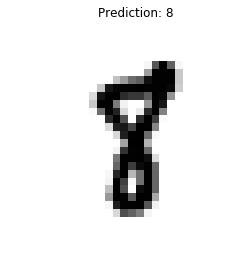

In [0]:
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(keras_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

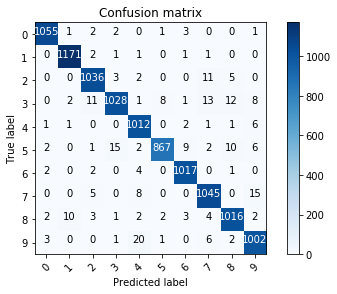

In [0]:
#Note this function was found online and was created by Yassine Ghouzam
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
validation_prediction = keras_model.predict(x_test)
# Convert predictions classes to one hot vectors 
validation_prediction_classes = np.argmax(validation_prediction, axis = 1)
# Convert validation observations to one hot vectors
y_test_one_hot = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion = confusion_matrix(y_test_one_hot, validation_prediction_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion, classes = range(10))


Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_6/keras_submission_cnn3.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.97442

In [0]:
results_df3=(pd.DataFrame({'TestName': 'Third Dense CNN',
   'NumberOfLayers': [7],
   'NodesPerLayer': [512],
   'ProcessingTime': [time3],
   'TrainingSetAccuracy': [score3[1]],
   'TestSetAccuracy': [0.97442]}))
results_df3.set_index('TestName', inplace=True)
results_df3

,NumberOfLayers,NodesPerLayer,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,
Third Dense CNN,7,512,00:00:46.031852,0.976095,0.97442


# Fourth Tensorflow Model Training with Keras

### Model Definition and Training

In [0]:
batch_size = 100
epochs = 20
num_classes = 10

#Running a sequence
keras_model = Sequential()
keras_model.add(Dense(784, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(784, activation='relu', input_shape=(784,)))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(num_classes, activation='softmax'))

keras_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


In [0]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_7 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_8 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [0]:
start=datetime.datetime.now()
keras_model.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, verbose=1, 
                validation_data=(x_test, y_test))
end=datetime.datetime.now()
time4=end-start
print("Time required to fit",end-start)
score4=keras_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 3s 81us/step - loss: 0.2929 - acc: 0.9097 - val_loss: 0.1255 - val_acc: 0.9593
Epoch 2/20
31500/31500 [==============================] - 2s 71us/step - loss: 0.1194 - acc: 0.9636 - val_loss: 0.1021 - val_acc: 0.9685
Epoch 3/20
31500/31500 [==============================] - 2s 71us/step - loss: 0.0830 - acc: 0.9739 - val_loss: 0.0985 - val_acc: 0.9725
Epoch 4/20
31500/31500 [==============================] - 2s 71us/step - loss: 0.0648 - acc: 0.9804 - val_loss: 0.0867 - val_acc: 0.9768
Epoch 5/20
31500/31500 [==============================] - 2s 70us/step - loss: 0.0509 - acc: 0.9849 - val_loss: 0.0944 - val_acc: 0.9776
Epoch 6/20
31500/31500 [==============================] - 2s 70us/step - loss: 0.0426 - acc: 0.9869 - val_loss: 0.0989 - val_acc: 0.9771
Epoch 7/20
31500/31500 [==============================] - 2s 70us/step - loss: 0.0379 - acc: 0.9886 - val_loss: 0.1257 - val_acc

In [0]:
keras_submission = pd.DataFrame()
keras_submission['Label'] = keras_model.predict_classes(mnist_test_scaled, verbose=1)
keras_submission.index += 1
keras_submission.index.name = 'ImageId'

28000/28000 [==============================] - 1s 34us/step


Run model on test dataset

### Model Results and Submission

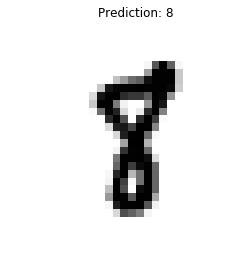

In [0]:
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(keras_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

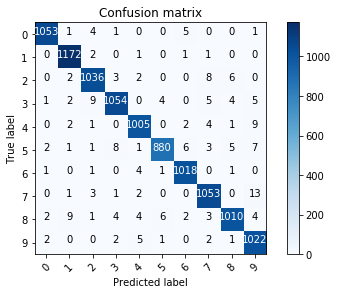

In [0]:
#Note this function was found online and was created by Yassine Ghouzam
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
validation_prediction = keras_model.predict(x_test)
# Convert predictions classes to one hot vectors 
validation_prediction_classes = np.argmax(validation_prediction, axis = 1)
# Convert validation observations to one hot vectors
y_test_one_hot = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion = confusion_matrix(y_test_one_hot, validation_prediction_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion, classes = range(10))


Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_6/keras_submission_cnn4.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.97800

In [0]:
results_df4=(pd.DataFrame({'TestName': 'Fourth Dense CNN',
   'NumberOfLayers': [5],
   'NodesPerLayer': [784],
   'ProcessingTime': [time4],
   'TrainingSetAccuracy': [score4[1]],
   'TestSetAccuracy': [0.97800]}))
results_df4.set_index('TestName', inplace=True)
results_df = pd.concat([results_df,results_df2,results_df3,results_df4], ignore_index=False)
results_df

,NumberOfLayers,NodesPerLayer,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,,,
Initial Dense CNN,5,512,00:00:46.339138,0.979524,0.98000
Second Dense CNN,3,300,00:00:38.751420,0.979143,0.97471
Third Dense CNN,7,512,00:00:46.031852,0.976095,0.97442
Fourth Dense CNN,5,784,00:00:45.756806,0.981238,0.97800


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:223: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  data = data.fillna(fillna)


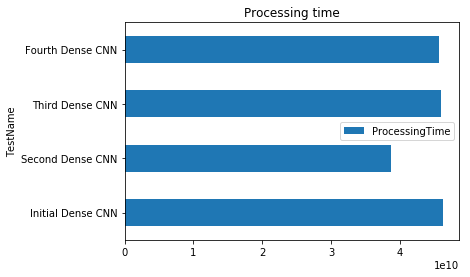

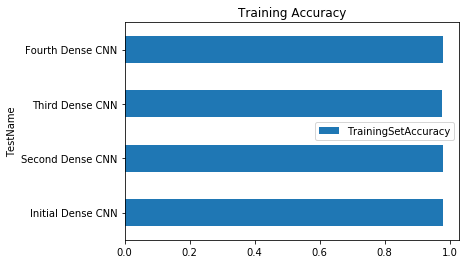

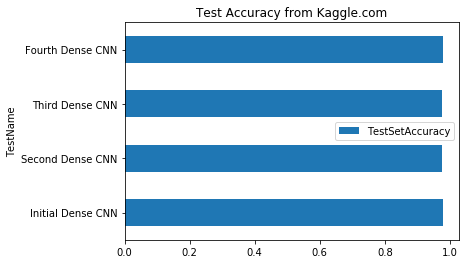

In [0]:
results_df[['ProcessingTime']].plot(kind='barh', title='Processing time')
results_df[['TrainingSetAccuracy']].plot(kind='barh', title='Training Accuracy')
results_df[['TestSetAccuracy']].plot(kind='barh', title='Test Accuracy from Kaggle.com')
plt.show()

# Recommendations

Of the methods tested, leveraging five layers with 512 nodes yielded the highest performance, however it is clear that there are several other approaches possible here, and that many other possible topology combinations may yield a higher performance level.